In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.lines as lines
import time
import math

In [2]:
# Configuration variables
a = 2
q = 9
omega = 1.5

# ub = 0.1
# vb = 0
# velocity_boundary = np.array([ub,vb])

rho_in_value, rho_out_value = 1.001, 0.999

nx = 20
ny = 20
L = ny
X, Y = np.meshgrid(np.arange(0,nx+2), np.arange(0,ny+2))

# Density weight contribution along the q different directions
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# Velocity components
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1],    # Velocity x-component
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])   # Velocity y-component

# debug flags
collision = True

In [3]:
def f_eq(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm,anm->nm',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def f_eq_i(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,an->n', c_ai.T[i], u)
        uu = np.einsum('an,an->n',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def rho_in():
    f = np.einsum("i,j->ij", w_i, np.ones((nx+2))*rho_in_value)
    rho = np.einsum("ij->j", f)
    return rho

def rho_out():
    f = np.einsum("i,j->ij", w_i, np.ones((nx+2))*rho_out_value)
    rho = np.einsum("ij->j", f)
    return rho


def plot_density(arr, plt_index=None):
    %matplotlib inline
    
    fig, ax = plt.subplots()
    if plt_index is not None:
        ax.set_title(f"Step {plt_index}")
    
#     line_top = lines.Line2D([0.5, 0.5+nx],
#                         [0.5, 0.5],
#                         color ='black')
#     line_bottom = lines.Line2D([0.5, 0.5+nx],
#                         [0.5+ny, 0.5+ny],
#                         color ='black')
#     ax.add_line(line_top)
#     ax.add_line(line_bottom)

    ax.add_patch(Rectangle((0.5,0.5), nx, ny, fill = False))
    ax.imshow(arr)
        

In [4]:
def stream_poiseuille(f_inm, rho, u):
    # Pressure gradient
    feq_star = f_eq(rho,u)
    for i in range(9):
        f_inm[:,:,0] = f_eq_i(rho_in(), u[:,:,ny]) + (f_inm[:,:,ny] - feq_star[:,:,ny])
        f_inm[:,:,ny+1] = f_eq_i(rho_out(), u[:,:,1]) + (f_inm[:,:,1] - feq_star[:,:,1])
        
#     plot_density(np.einsum("ijk->jk", f_inm))
#     plt.show()
    
    # Streaming
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift = c_ai.T[i], axis=[1,0])
    
    rho = np.einsum("ijk->jk", f_inm)
    u = np.einsum('ai,ijk->ajk',c_ai,f_inm)/rho
    
    # Collision
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm->nm',u**2)
        term = rho*w_i[i]*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)

    f_inm = f_inm + (omega * (feq - f_inm))

    for i in range(1, ny+1):
        # top boundary
        
        f_inm[4,1,i] = f_inm[2,0,i]
        f_inm[7,1,i] = f_inm[5,0,i+1]
        f_inm[8,1,i] = f_inm[6,0,i-1]
        
        # bottom boundary
        
        f_inm[2,nx,i] = f_inm[4,nx+1,i]
        f_inm[5,nx,i] = f_inm[7,nx+1,i-1]
        f_inm[6,nx,i] = f_inm[8,nx+1,i+1]
        
    rho = np.einsum("ijk->jk", f_inm)
    u = np.einsum('ai,ijk->ajk',c_ai,f_inm)/rho
#     plot_density(rho)

    return f_inm, rho, u

In [5]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
# f[:, nx//2, ny//2] = 0.99*f[:, nx//2, ny//2]
# f[:, nx//4, ny//4] = 1.01*f[:, nx//4, ny//4]

In [6]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
rho = np.einsum("ijk->jk", f)
u = np.einsum('ai,ijk->ajk',c_ai,f)/rho

In [7]:
f, rho, u = stream_poiseuille(f,rho,u)

In [8]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
rho = np.einsum("ijk->jk", f)
u = np.einsum('ai,ijk->ajk',c_ai,f)/rho

slen = 50
for i in range(slen):
    f, rho, u = stream_poiseuille(f,rho,u)


### Init

In [9]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
rho = rho_init = np.einsum("ijk->jk", f)
u = u_init = np.einsum('ai,ijk->ajk',c_ai,f)/rho

0


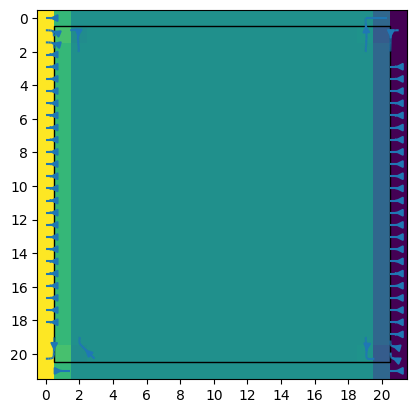

10


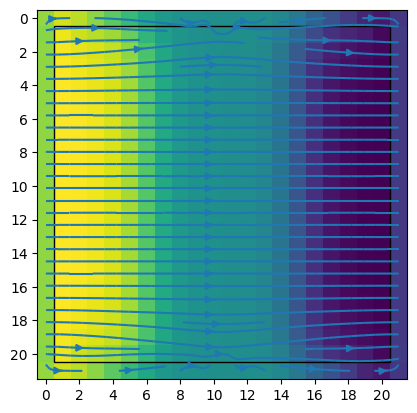

20


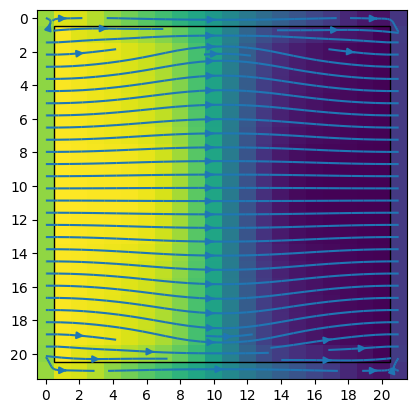

30


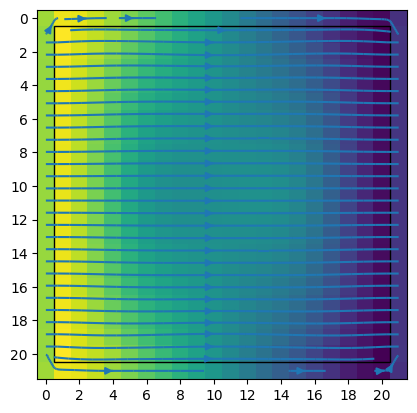

40


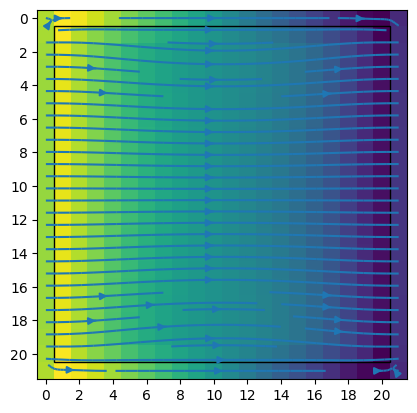

50


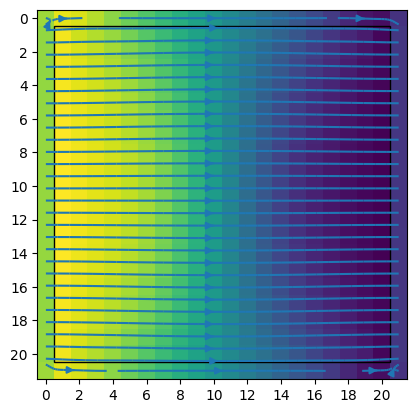

60


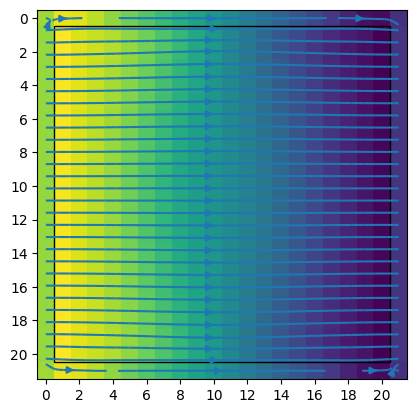

70


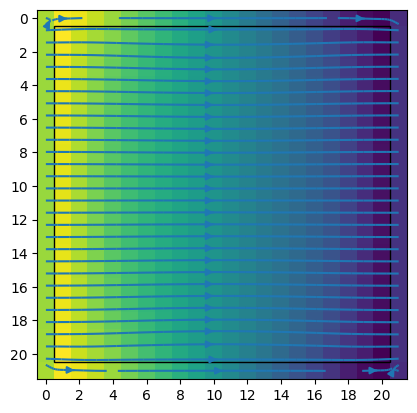

80


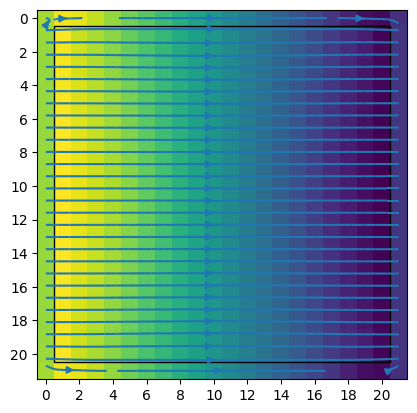

90


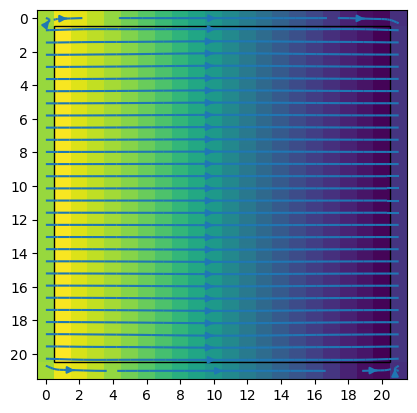

In [10]:
def stream_loop(f, rho, u, iter_length, value_log_period, plot):
    u_periodic = np.empty((iter_length//value_log_period, nx+2))
    u_inlet_periodic = np.empty((iter_length//value_log_period, nx+2))
    r_periodic = np.empty((iter_length//value_log_period, nx+2))

    for i in range(iter_length):
        f, rho, u = stream_poiseuille(f, rho, u)
        if i%value_log_period==0:
            print(i)

            u_periodic[i//value_log_period] = u[0,:,ny//2]
            u_inlet_periodic[i//value_log_period] = u[0,:,1]
            r_periodic[i//value_log_period] = rho[:,ny//2]
            
            if plot:
                plot_density(rho)
                plt.streamplot(X, Y, u[0], u[1])
                plt.xticks(range(0,nx+2,2))
                plt.yticks(range(0,ny+2,2))
                plt.show()
            
    return u_periodic, u_inlet_periodic, r_periodic

u_periodic, u_inlet_periodic, r_periodic = stream_loop(f, rho, u, 100, 10, plot=True)


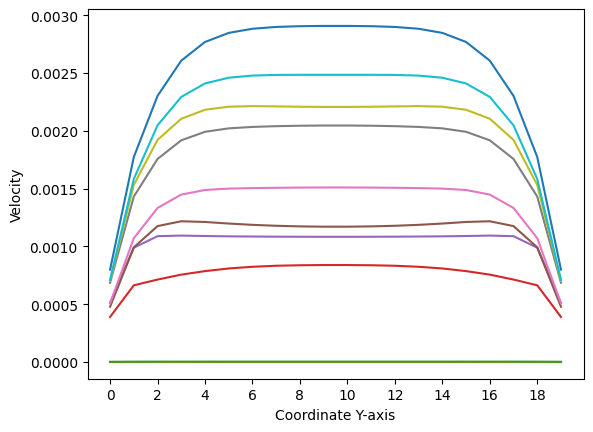

In [11]:
# Plot of velocity

plt.plot(u_init[0,:,10][1:-1])
for i in range(u_periodic.shape[0]):
    plt.plot(u_periodic[i][1:-1])
plt.xticks(range(0,nx,2))
plt.xlabel("Coordinate Y-axis")
plt.ylabel("Velocity")
plt.show()

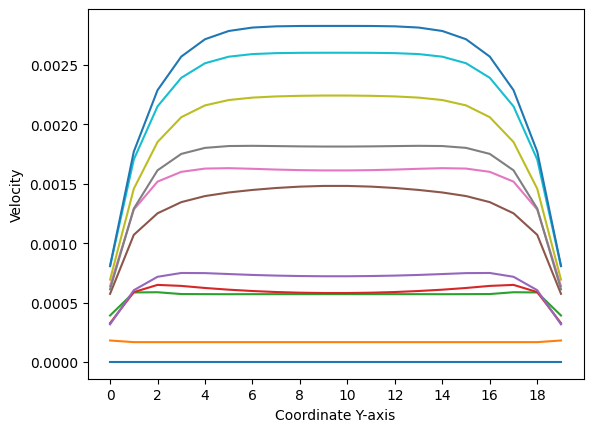

In [12]:
# Plot of velocity - inlet

plt.plot(u_init[0,:,1][1:-1])
for i in range(u_periodic.shape[0]):
    plt.plot(u_inlet_periodic[i][1:-1])
plt.xticks(range(0,nx,2))
plt.xlabel("Coordinate Y-axis")
plt.ylabel("Velocity")
plt.show()

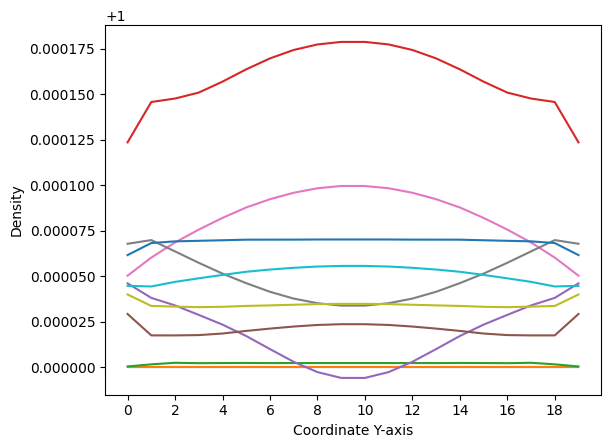

In [13]:
# Plot of density

plt.plot(rho_init[10][1:-1])
for i in range(r_periodic.shape[0]):
    plt.plot(r_periodic[i][1:-1])
plt.xticks(range(0,nx,2))
plt.xlabel("Coordinate Y-axis")
plt.ylabel("Density")
plt.show()

### Simulate for 10000 steps

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


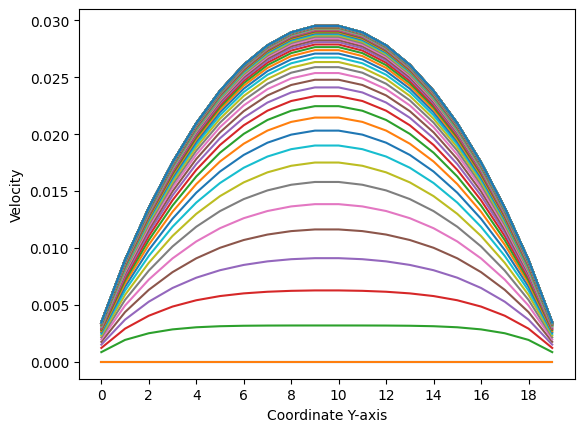

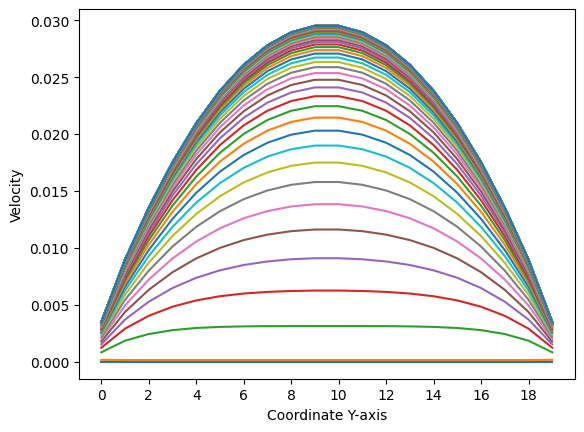

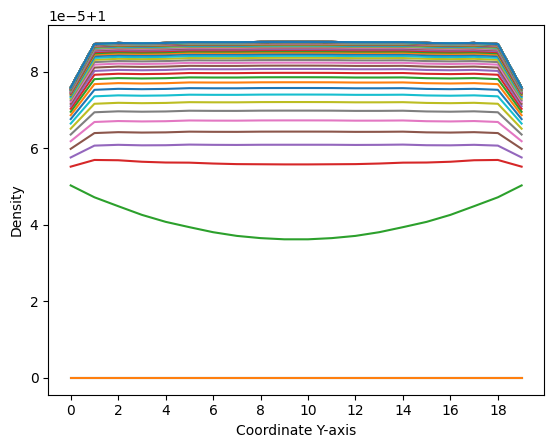

In [14]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
rho = np.einsum("ijk->jk", f)
u = np.einsum('ai,ijk->ajk',c_ai,f)/rho

u_periodic, u_inlet_periodic, r_periodic = stream_loop(f, rho, u, 10000, 100, plot=False)

# Plot of velocity

# delta_p = (rho_out_value - rho_in_value)/nx
# nu = (1/3)*((1/omega)-0.5)
# h = nx
# analytical_u = np.empty((nx))
# for i in range(nx):
#     analytical_u[i] = -(0.5/nu)*delta_p*i*(h-i)
# plt.plot(analytical_u)

plt.plot(u_init[0,:,ny//2][1:-1])
for i in range(u_periodic.shape[0]):
    plt.plot(u_periodic[i][1:-1])
plt.xticks(range(0,nx,2))
plt.xlabel("Coordinate Y-axis")
plt.ylabel("Velocity")
plt.show()

# Plot of velocity - inlet

plt.plot(u_init[0,:,1][1:-1])
for i in range(u_periodic.shape[0]):
    plt.plot(u_inlet_periodic[i][1:-1])
plt.xticks(range(0,nx,2))
plt.xlabel("Coordinate Y-axis")
plt.ylabel("Velocity")
plt.show()

# Plot of density

plt.plot(rho_init[ny//2][1:-1])
for i in range(r_periodic.shape[0]):
    plt.plot(r_periodic[i][1:-1])
plt.xticks(range(0,nx,2))
plt.xlabel("Coordinate Y-axis")
plt.ylabel("Density")
plt.show()

### Analytical

In [15]:
delta_p = (rho_out_value - rho_in_value)/(3*nx)
nu = (1/3)*((1/omega)-0.5)
h = nx
analytical_u = np.empty((nx))
for i in range(nx):
    analytical_u[i] = -(0.5/nu)*delta_p*i*(h-i)

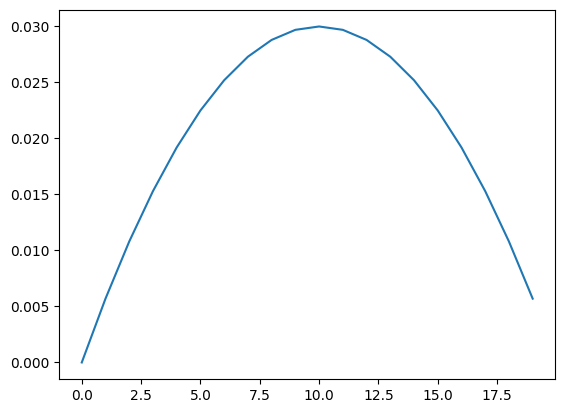

In [16]:
plt.plot(analytical_u)